In [7]:
%run _init_notebook.ipynb
%aimport approxmh.samplers
import os
import matplotlib.gridspec as gridspec
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.profiler
from approxmh.vae import ConvVAE
from approxmh.model_trainers import AdaptiveVAETrainer, AdaptiveFlowTrainer
from approxmh.distributions import create_serpentine, create_random_gaussian_mixture, IndependentMultivariateNormal, Funnel, PoorlyConditionedGaussian
from approxmh.samplers import AdaptiveVAESampler, MetropolisHastingsFilter, VAEGlobalMHFilter, VAEMetropolisWithinGibbsSampler
from approxmh.utilities import visualize_distribution, sample_from_tensor
from approxmh.likelihood_estimators import SISLikelihoodEstimator, IWLikelihoodEstimator
from approxmh.y_utils import *
from approxmh.distribution_metrics import CoordinateDistributionMetric, TotalVariation1d
from approxmh.rnvp import RNVP
from approxmh.pyro_samplers import NUTS
from approxmh.utilities import count_parameters, dataloader_from_tensor
from approxmh.ebm_distributions import MnistEBMDistribution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device: cuda


torch.Size([5, 1, 28, 28])
Device of images batch: cpu
Shape of images batch: torch.Size([256, 1, 28, 28])


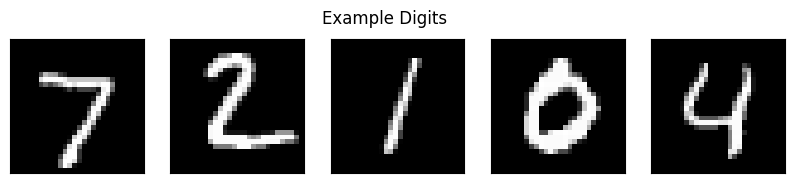

In [69]:
DATASET_DIR = '../datasets/'


class FastDataLoader:
    def __init__(self, tensor, batch_size=1, pin_memory=False, shuffle=False):
        self.dataset = tensor
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.len = tensor.shape[0]
        self.n_batches = (self.len - 1) // self.batch_size + 1
        self.index = None

    def __iter__(self):
        if self.shuffle:
            self.dataset = self.dataset[torch.randperm(self.len)]
        self.index = 0
        return self

    def __next__(self):
        if self.index == self.len:
            raise StopIteration
        next_index = min(self.len, self.index + self.batch_size)
        result = self.dataset[self.index : next_index]
        self.index = next_index
        return result

    def __len__(self):
        return self.n_batches



class PreprocessedUnlabeledDataset:
    def __init__(self, original_dataset, savefile=None):
        if os.path.exists(savefile):
            self.tensor = torch.load(savefile, weights_only=True)
            return
        elements = []
        for x, y in original_dataset:
            elements.append(x)
        self.tensor = torch.stack(elements)
        if savefile is not None:
            torch.save(self.tensor, savefile)

    def __getitem__(self, i):
        return self.tensor[i]

    def __len__(self):
        return self.tensor.shape[0]


def preprocessed_unlabeled_tensor(original_dataset, savefile=None, shuffle=False):
    if os.path.exists(savefile):
        return torch.load(savefile, weights_only=True)
    elements = []
    for x, y in original_dataset:
        elements.append(x)
    result = torch.stack(elements)[torch.randperm(len(elements))]
    if savefile is not None:
        torch.save(result, savefile)
    return result


# im_sz = 32  # because this is how the EBM was trained
transform = transforms.Compose([
#    transforms.Resize(im_sz),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean 0.5 and std 0.5
])

train_dataset = datasets.MNIST(root=DATASET_DIR, train=True, download=True, transform=transform)
val_dataset = datasets.MNIST(root=DATASET_DIR, train=False, download=True, transform=transform)
train_dataset = PreprocessedUnlabeledDataset(train_dataset, DATASET_DIR + 'mnist_train_preprocessed.pth')
val_dataset = PreprocessedUnlabeledDataset(val_dataset, DATASET_DIR + 'mnist_val_preprocessed.pth')

# Create dataloaders for training and testing datasets
train_loader = FastDataLoader(train_dataset.tensor, batch_size=256, shuffle=True)
val_loader = FastDataLoader(val_dataset.tensor, batch_size=8192, shuffle=False)

# Images to show and to test reconstruction quality
n_display_imgs = 5
display_imgs = torch.stack([val_dataset[i] for i in range(n_display_imgs)])
print(display_imgs.shape)
im_sz = display_imgs.shape[3]

fig, axs = plt.subplots(ncols=5, figsize=(10, 2))
fig.suptitle('Example Digits')
for ax, img in zip(axs, display_imgs):
    ax.imshow(img[0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

# Check the shape of the data
data_iter = iter(train_loader)
images = next(data_iter)
print(f"Device of images batch: {images.device}")
print(f"Shape of images batch: {images.shape}")  # e.g., torch.Size([64, 1, 28, 28])

In [83]:
LOAD_KNOWLEDGE = False
latent_dim = 8
vae_filename = f'../models/mnist_convvae_latent_{latent_dim}_bs256'

vae = ConvVAE(
    data_dim=images.shape[2],
    latent_dim=latent_dim,
    device=device
)
if LOAD_KNOWLEDGE:
    vae.load_knowledge(vae_filename)
else:
    vae.init_weights()
vae.to(device)

data_dim: 28 
dim1: 14 
dim2: 7 
dim3: 3 
flat_dim: 288


convvae_latent8

In [84]:
vae_trainer = AdaptiveVAETrainer(
    target=None,
    model=vae,
    model_log_likelihood=None,
    optimizer='adam',
    lr=1e-2,
    wd=1e-4,
    loss_annealing_epochs=1,
    no_latent_loss_epochs=0,
    warmup_epochs=1,
    grad_clip=None,
    scheduler="steplr",
    scheduler_step_size=150,
    scheduler_gamma=0.1,
)

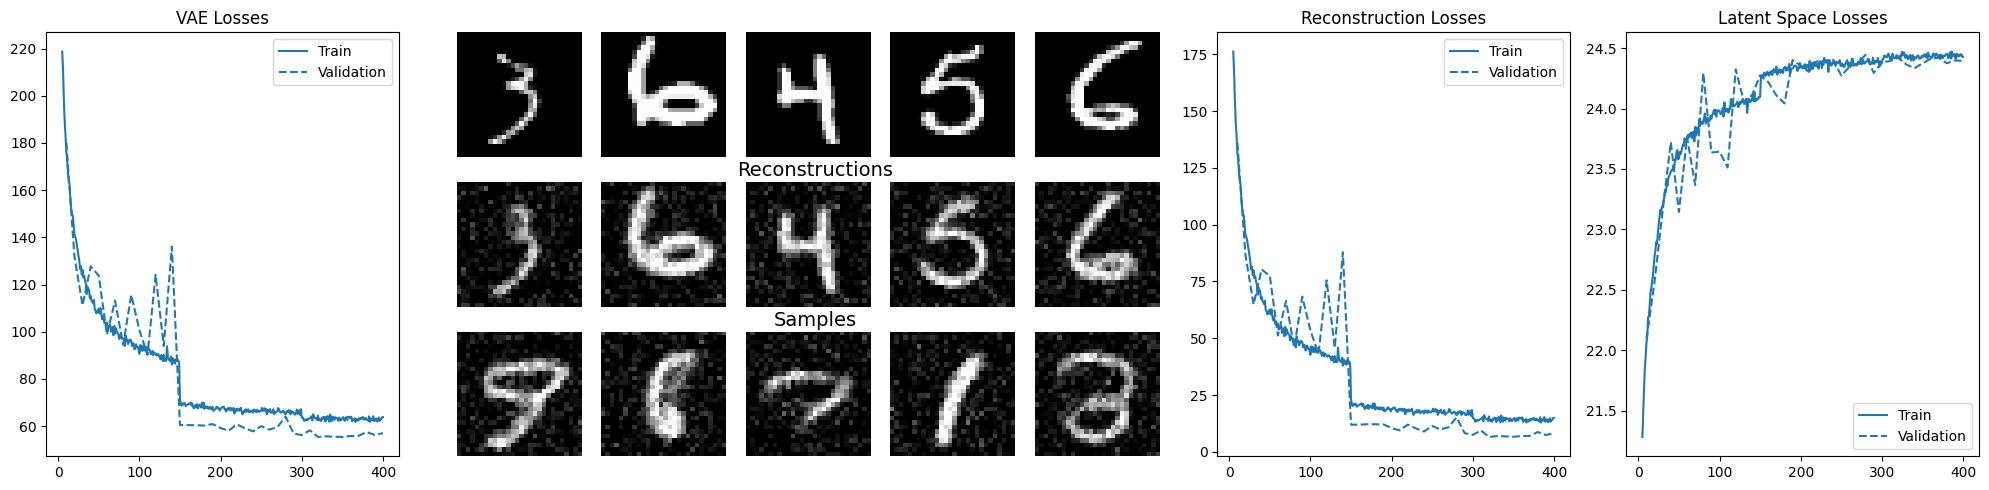

In [86]:
# %%time
def visualize_training(n_epochs=300):
    plot_interval = 10
    from_epoch = 5
    metric = CoordinateDistributionMetric(TotalVariation1d(), projection_coordinates=(0,1))
    models = [
        ('VAE', vae, vae_trainer, 'tab:blue'),
#        ('Flow', flow, flow_trainer, 'tab:orange')
    ]
    n_models = len(models)
    #for _, _, trainer, _ in models:
    #    trainer.clear_logs()
    
    test_logs = defaultdict(list)

    def plot_statistic(self, model_id, statistic_name, *args, **kwargs):
        model_name, _, _, color = models[model_id]
        statistic = test_logs[model_name + '_' + statistic_name]
        return self.plot(np.arange(1, len(statistic)+1), statistic, c=color, *args, **kwargs)
    mpl.axes.Axes.plot_statistic = plot_statistic
        
    
    vae.train()
    # flow.train()

    '''with torch.profiler.profile(
        # schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('../log/vae_mnist_training'),
        record_shapes=False,
        profile_memory=False,
        with_stack=True
    ) as prof:'''

    for epoch_idx in range(1, n_epochs + 1):
        # for g in vae_trainer.optimizer.param_groups:
        #    g['lr'] = 1e-4
        is_display_epoch = epoch_idx == 1 or epoch_idx % plot_interval == 0
        
        for model_name, model, trainer, color in models:
           trainer.run_classic_epoch(train_loader, val_loader if is_display_epoch else None)    

        if is_display_epoch:
            clear_output(wait=True)
            fig = plt.figure(figsize=(20, 5))
            gs = gridspec.GridSpec(1, 4, width_ratios=[1, 2, 1, 1])
            
            ax1 = fig.add_subplot(gs[0, 0])
            ax1.set_title(f'VAE Losses')
            ax1.plot(*models[0][2].get_log('train_loss', from_epoch), label='Train', color=models[0][3])
            ax1.plot(*models[0][2].get_log('val_loss', from_epoch), label='Validation', linestyle='--', color=models[0][3])
            ax1.legend()

            ax = fig.add_subplot(gs[0, 2])
            ax.set_title(f'Reconstruction Losses')
            ax.plot(*models[0][2].get_log('train_recon_loss', from_epoch), label='Train', color=models[0][3])
            ax.plot(*models[0][2].get_log('val_recon_loss', from_epoch), label='Validation', linestyle='--', color=models[0][3])
            ax.legend()

            ax = fig.add_subplot(gs[0, 3])
            ax.set_title(f'Latent Space Losses')
            ax.plot(*models[0][2].get_log('train_latent_loss', from_epoch), label='Train', color=models[0][3])
            ax.plot(*models[0][2].get_log('val_latent_loss', from_epoch), label='Validation', linestyle='--', color=models[0][3])
            ax.legend()

            vae.eval()
            monitor_imgs = sample_from_tensor(val_dataset, 5)
            # monitor_imgs = vae.sample((5,)).to('cpu')
            with torch.no_grad():
                monitor_img_reconstructions = vae.reconstruct(monitor_imgs.to(device)).to('cpu')
                sample_imgs = vae.sample((n_display_imgs,)).to('cpu')
            imgs_to_plot = torch.stack((monitor_imgs, monitor_img_reconstructions, sample_imgs))
            vae.train()
            
            gs_right = gridspec.GridSpecFromSubplotSpec(3, n_display_imgs, subplot_spec=gs[0, 1])
            fig.text(0.41, 0.65, "Reconstructions", fontsize=14, ha="center", va="center")
            fig.text(0.41, 0.35, "Samples", fontsize=14, ha="center", va="center")
            
            for i in range(3):
                for j in range(n_display_imgs):
                    ax = fig.add_subplot(gs_right[i, j])
                    ax.imshow(imgs_to_plot[i][j][0], cmap='gray', vmin=-1, vmax=1)
                    ax.axis('off')
            
            plt.tight_layout()         
            plt.show()
    
    vae.eval()
    # flow.eval()

visualize_training(n_epochs=400)

In [88]:
vae_filename = f'../models/mnist_convvae_latent_{latent_dim}_bs256'
SAVE_KNOWLEDGE = False
if SAVE_KNOWLEDGE:
    vae.save_knowledge(vae_filename)

In [65]:
for param_name, param in vae.named_parameters():
    print(f'{param_name}: {torch.numel(param)}')
print(f'Total: {sum([torch.numel(param) for param in vae.parameters()])}')

decoder_log_var: 1
encoder.0.weight: 288
encoder.0.bias: 32
encoder.1.weight: 32
encoder.1.bias: 32
encoder.4.weight: 9216
encoder.4.bias: 32
encoder.5.weight: 32
encoder.5.bias: 32
encoder.8.weight: 9216
encoder.8.bias: 32
encoder.9.weight: 32
encoder.9.bias: 32
encoder.13.weight: 4608
encoder.13.bias: 16
decoder.0.weight: 2304
decoder.0.bias: 288
decoder.1.weight: 288
decoder.1.bias: 288
decoder.5.weight: 9216
decoder.5.bias: 32
decoder.6.weight: 32
decoder.6.bias: 32
decoder.9.weight: 9216
decoder.9.bias: 32
decoder.10.weight: 32
decoder.10.bias: 32
decoder.13.weight: 288
decoder.13.bias: 1
Total: 45714


In [66]:
ebm_im_sz = 32
img_upsampler = torch.nn.Upsample(size=ebm_im_sz)
target = MnistEBMDistribution(device=device)

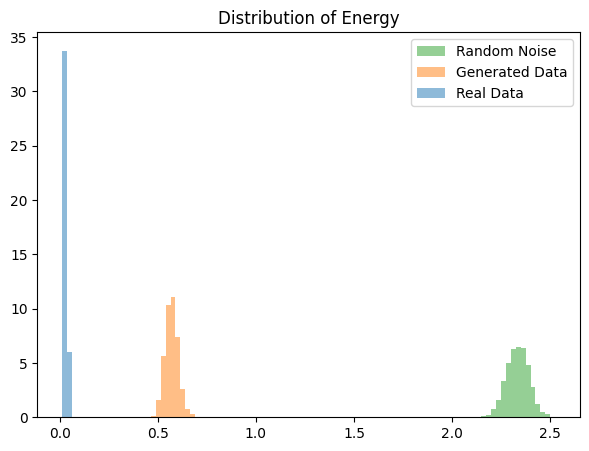

In [89]:
def analyze_log_likelihoods():
    n_samples = 1024
    labels = ['Real Data', 'Generated Data', 'Random Noise']
    val_sample = sample_from_tensor(val_dataset, n_samples).to(device)
    generated_sample = vae.sample((n_samples,))
    noise_sample = 2 * torch.rand((n_samples, 1, im_sz, im_sz), device=device) - 1
    samples = [val_sample, generated_sample, noise_sample]
    sample_likelihoods = [to_numpy(-target.log_prob(sample)) for sample in samples]

    fig, ax = plt.subplots(figsize=(7,5))
    ax.set_title('Distribution of Energy')
    ax.hist(
        sample_likelihoods,
        bins=100,
        histtype='stepfilled',
        alpha=0.5,
        label=labels,
        density=True
    )
    ax.legend()

analyze_log_likelihoods()

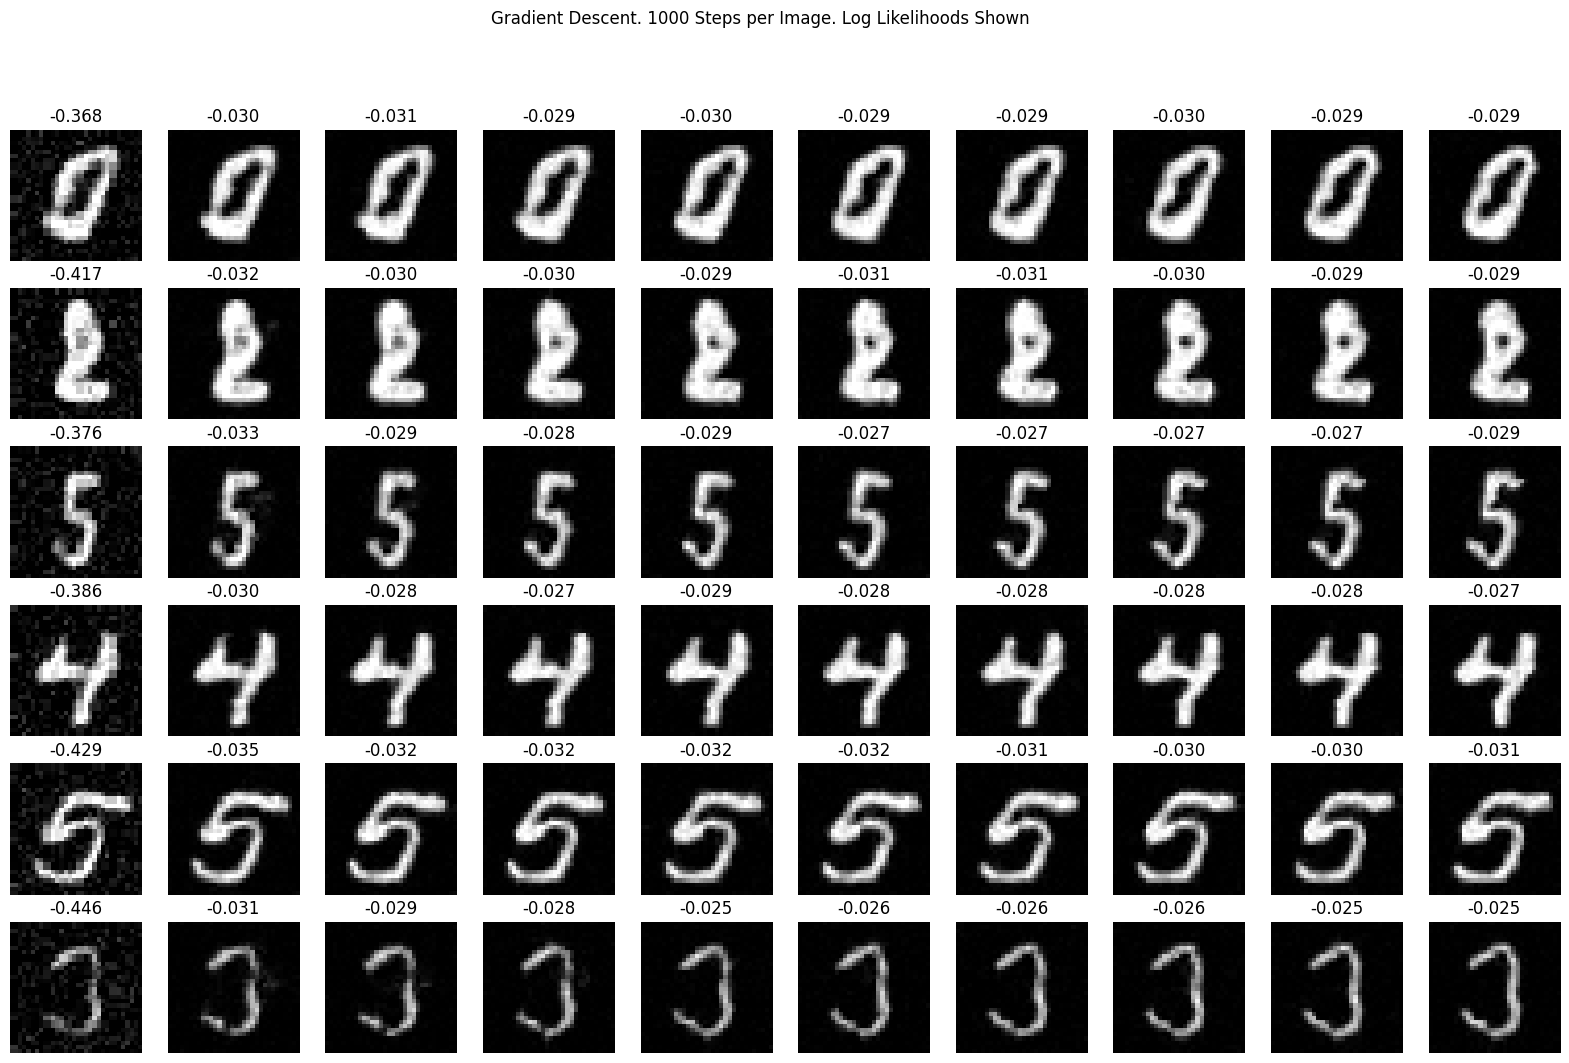

In [37]:
def sample_ebm_ula(images_in_chain=10, n_chains=6, steps_per_image=1_000, step_size=1):
    #chain_states = 2 * torch.rand((n_chains, 1, ebm_im_sz, ebm_im_sz), device=device) - 1
    chain_states = img_upsampler(vae.sample((n_chains,)))
    torch.cuda.empty_cache()
    #chain_states = (train_dataset.tensor[:n_chains]).clone().to(device)
    #chain_states += torch.randn_like(chain_states) * 1  # torch.linspace(0.01, 1, n_chains, device=device)[:, None, None, None]
    result = [chain_states.clone()]
    chain_states.requires_grad_()
    for step in range((images_in_chain - 1) * steps_per_image):
        log_likelihood_gradients = torch.autograd.grad(target.log_prob(chain_states, need_upsample=False).sum(), [chain_states])[0]
        chain_states.detach_().requires_grad_()
        with torch.no_grad():
            chain_states.add_(step_size * log_likelihood_gradients + 7.5e-3 * torch.randn_like(chain_states))
        if (step + 1) % steps_per_image == 0:
           result.append(chain_states.clone().detach())

    fig, axs = plt.subplots(ncols=images_in_chain, nrows=n_chains, figsize=(20, 12))
    fig.suptitle(f'Gradient Descent. {steps_per_image} Steps per Image. Log Likelihoods Shown')
    for i in range(images_in_chain):
        log_probs = target.log_prob(result[i], need_upsample=False)
        for j in range(n_chains):
            axs[j][i].imshow(result[i][j][0].to('cpu'), cmap='gray', vmin=-1, vmax=1)
            axs[j][i].axis('off')
            axs[j][i].set_title(f'{log_probs[j].item():0.3f}')

sample_ebm_ula()

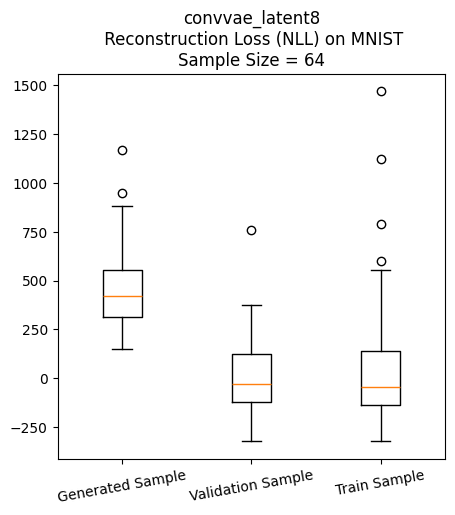

In [90]:
def analyze_reconstruction_quality():
    n_samples = 64
    n_display_samples = 4

    vae.eval()
    gen_sample = vae.sample((n_samples,))
    val_sample = sample_from_tensor(val_dataset, n_samples).to(device)
    train_sample = sample_from_tensor(train_dataset, n_samples).to(device)
    sample_types = [
        ('Generated', gen_sample),
        ('Validation', val_sample),
        ('Train', train_sample)
    ]
    n_sample_types = len(sample_types)

    recon_losses = []  # reconstruction losses
    with torch.no_grad():
        for sample_name, sample in sample_types:
            recon_losses.append(to_numpy(-vae.decoder_distribution(vae.encode(sample)).log_prob(sample)))

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.boxplot(
        recon_losses,
        tick_labels=[sample_name + ' Sample' for sample_name, sample in sample_types],
    )
    ax.set_xticklabels(ax.get_xticklabels(),rotation=10)
    ax.set_title(f'{vae}\n Reconstruction Loss (NLL) on MNIST\nSample Size = {n_samples}')

analyze_reconstruction_quality()

self.target.log_prob(new_x) - self.target.log_prob(x): -0.048609137535095215
z1_conditional.log_prob(x) -223.49169921875
z2_conditional.log_prob(new_x) -44.45989990234375
tensor([0.], device='cuda:0')
self.target.log_prob(new_x) - self.target.log_prob(x): 0.0047872066497802734
z1_conditional.log_prob(x) -209.13209533691406
z2_conditional.log_prob(new_x) -21.681108474731445
tensor([0.], device='cuda:0')
self.target.log_prob(new_x) - self.target.log_prob(x): 0.004367351531982422
z1_conditional.log_prob(x) -217.0321807861328
z2_conditional.log_prob(new_x) -2.698962688446045
tensor([0.], device='cuda:0')
self.target.log_prob(new_x) - self.target.log_prob(x): -0.002777695655822754
z1_conditional.log_prob(x) -206.093017578125
z2_conditional.log_prob(new_x) -9.6669921875
tensor([0.], device='cuda:0')
self.target.log_prob(new_x) - self.target.log_prob(x): -0.020881175994873047
z1_conditional.log_prob(x) -219.33282470703125
z2_conditional.log_prob(new_x) -19.615196228027344
tensor([0.], device=

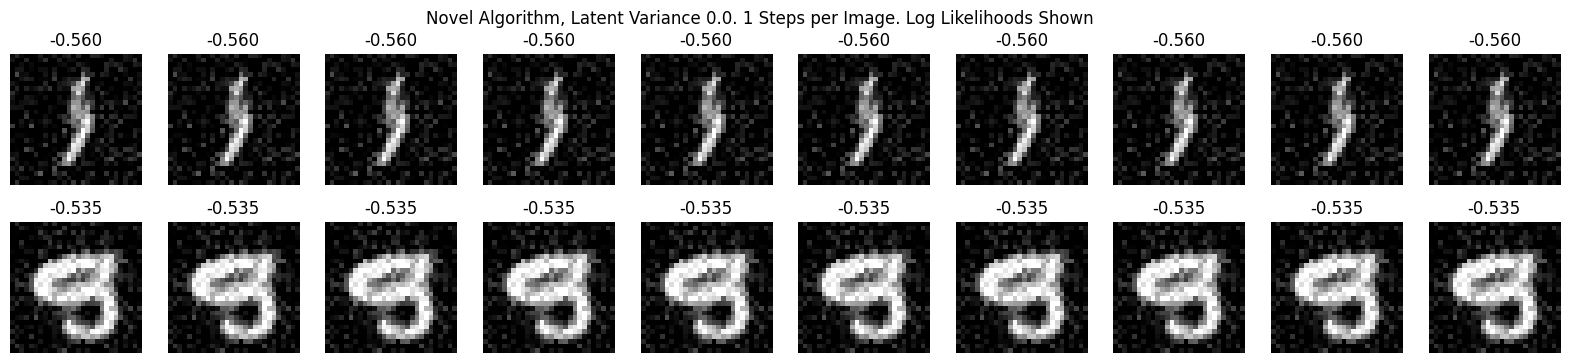

In [77]:
from approxmh.samplers import VAEMetropolisWithinGibbsSampler
# latent_noise_variance: variance of the proposal distribution in the latent space
def novel_sampling_method_on_mnist(images_in_chain=10, n_chains=2, steps_per_image=1, latent_noise_variance=0.):
    samples_per_chain = (images_in_chain - 1) * steps_per_image + 1
    sampler = VAEMetropolisWithinGibbsSampler(vae, target, latent_noise_variance)
    result = torch.stack([sampler.sample(samples_per_chain)[::steps_per_image] for i in range(n_chains)])

    fig, axs = plt.subplots(ncols=images_in_chain, nrows=n_chains, figsize=(2*images_in_chain, 2*n_chains))
    fig.suptitle(f'Novel Algorithm, Latent Variance {latent_noise_variance}. {steps_per_image} Steps per Image. Log Likelihoods Shown')
    for i in range(n_chains):
        log_probs = target.log_prob(result[i])
        for j in range(images_in_chain):
            axs[i][j].imshow(result[i][j][0].to('cpu'), cmap='gray', vmin=-1, vmax=1)
            axs[i][j].axis('off')
            axs[i][j].set_title(f'{log_probs[j].item():0.3f}')

novel_sampling_method_on_mnist()